<a href="https://colab.research.google.com/github/kim-jeonghyun/basic_ml/blob/main/Binary_Classification_with_Preprocessing_Cross_Validation_and_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 사기 거래 탐지를 위한 이진 분류: 데이터 전처리, 교차 검증 및 하이퍼 파라미터 튜닝 중심으로


작성자 [김정현](kimjeonghyun.jkim@gmail.com)  
참고 [Basic Binary Classification using Scikit-learn](https://colab.research.google.com/drive/16oy4iiX6IKcKslCyMcEjGzbmmpptsxk2)


## 1. 서론

- 지난 번 Basic Binary Classfication using Scikit-learn 노트북에서는 머신 러닝 과제 중에서 가장 단순하면서 범용적으로 쓰이는 이진 분류 (Binary Classification) 과제에 대하여 간단히 정리하고, Scikit-learn을 사용한 기초적인 이진 분류 모델 구축 방법을 배웠음
- 이 노트북에서는 그 기초 위에서 더욱 구체적이고 심화된 기술들을 추가하여 모델 성능 최적화하는 방법을 배울 것임
 1. 데이터 전처리 심화
 2. 교차 검증의 실제 적용
 3. 하이퍼 파라미터 튜닝 연습

 이와 같은 실습을 위하여 보다 대규모이며, 이진 클래스의 분포가 불균형하고, 다양한 특성을 가지고 있는
 데이터셋인 '신용카드 사기거래 데이터셋'을 활용할 예정. 또한 이 데이터셋에 접근하기 위하여 데이터 사이언스 분야에서 널리 사용하는 Kaggle 사이트에 접근하고, Kaggle API를 활용해 Kaggle이 데이터를 쉽게 다운로드 받아 분석하는 방법도 시도해 볼 것임

## 2. 데이터 준비

- '신용카드 사기거래 데이터셋'은 금융 거래 데이터를 기반으로 함
- 하나의 instance는 하나의 거래에 대한 정보를 담고 있음
- 각 거래는 다양한 속성을 포함하며, 레이블은 이 거래가 정상인지 아니면 사기인지를 나타냄
- 데이터셋의 각 속성은 거래의 특징을 나타내며, 일부는 익명화 처리되어 있어 직접적인 식별은 어려움  

이 데이터셋의 특성을 정리하면 다음과 같음

  1. 데이터 불균형 : 정상 거래에 비해 사기 거래의 비율이 현저히 낮음  
  실제 현실 세계의 많은 분류 문제들이 이와 같이 불균형한 레이블 분포를 보임  
  2. 특성 익명화 : 개인정보 보호를 위해 거래 관련 대부분의 특성들이 익명화 처리되어 있음
  3. 다양한 성격의 특성들 : 거래 금액, 거래 시간 등의 다양한 특성들이 포함되어 정상/사기 거래 여부를 식별할 수 있는 정보 분석 가능  

### 2-1. Download Dataset  

[Kaggle의 해당 데이터셋](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) 에서 이번에 다루는 데이터셋을 직접 다운로드할 수 있지만 kaggle API를 활용해 커널에서 데이터를 다운로드를 받을 수 있다. 두가지 방법 모두 kaggle 사이트에 회원가입을 해야하며, kaggle에서 다양한 데이터셋과 모범 코드를 확인할 수 있고, 자신의 실력을 증명할 수 있는 competition 참여까지 할 수 있으므로, 만약 계정이 없다면 회원가입을 할 것을 추천한다.

참고 :   
[official kaggle API repo](https://github.com/Kaggle/kaggle-api)

In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle

kaggle settings 페이지에서 Create New Token 버튼을 클릭하면, 나의 username 정보와 key 정보가 저장된 kaggle.json 파일이 다운로드 된다. 이 정보를 내 project directory에 ~/.kaggle/kaggle.json로 저장하면, kaggle API를 활용해 데이터셋을 다운로드 받을 수 있다.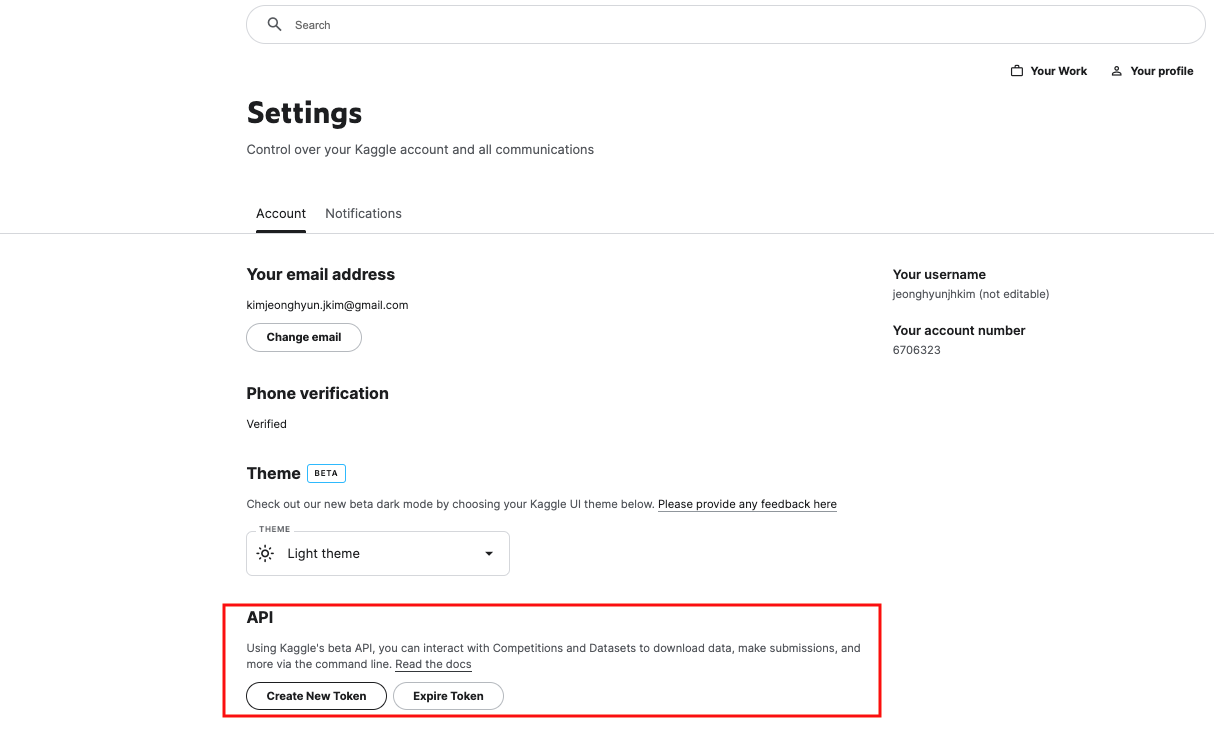


In [ ]:
!echo '{"username":"username","key":"user-key"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud

401 - Unauthorized - Unauthenticated


In [ ]:
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


위와 같은 과정을 거치면, creditcard.csv 파일이 현재 폴더에 저장되어 불러와 분석을 할 수 있다.

### 2-2. 데이터 탐색   
- 데이터셋의 기본적인 구조를 이해하고, 결측치 및 이상치가 있는지 빠르게 확인하는 과정
- 이를 통해 앞으로 과제를 수행하기 위해 어떤 절차를 거칠 것인지 계획을 세우는데 도움이 됨

In [ ]:
import pandas as pd
df = pd.read_csv('creditcard.csv')

In [ ]:
# 기본적인 데이터 정보 확인

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- 정상/사기 거래를 나타내는 Class 속성만 정수 타입이고, 나머지는 모두 실수 타입이며
- 284807개의 instance를 가지고 있음
- 결측치가 없음

In [ ]:
# 데이터의 레이블 분포 확인
print(df['Class'].value_counts())

0    284315
1       492
Name: Class, dtype: int64


정상 거래 284315건, 사기거래 492건으로 전체 거래 중 사기 거래의 비율이 0.17% 정도 밖에 안됨

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


실수 타입의 X 특성들의 분포를 전반적으로 살펴볼 수 있음

In [ ]:
features = [col for col in df.columns if not col=='Class']
df[features].describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


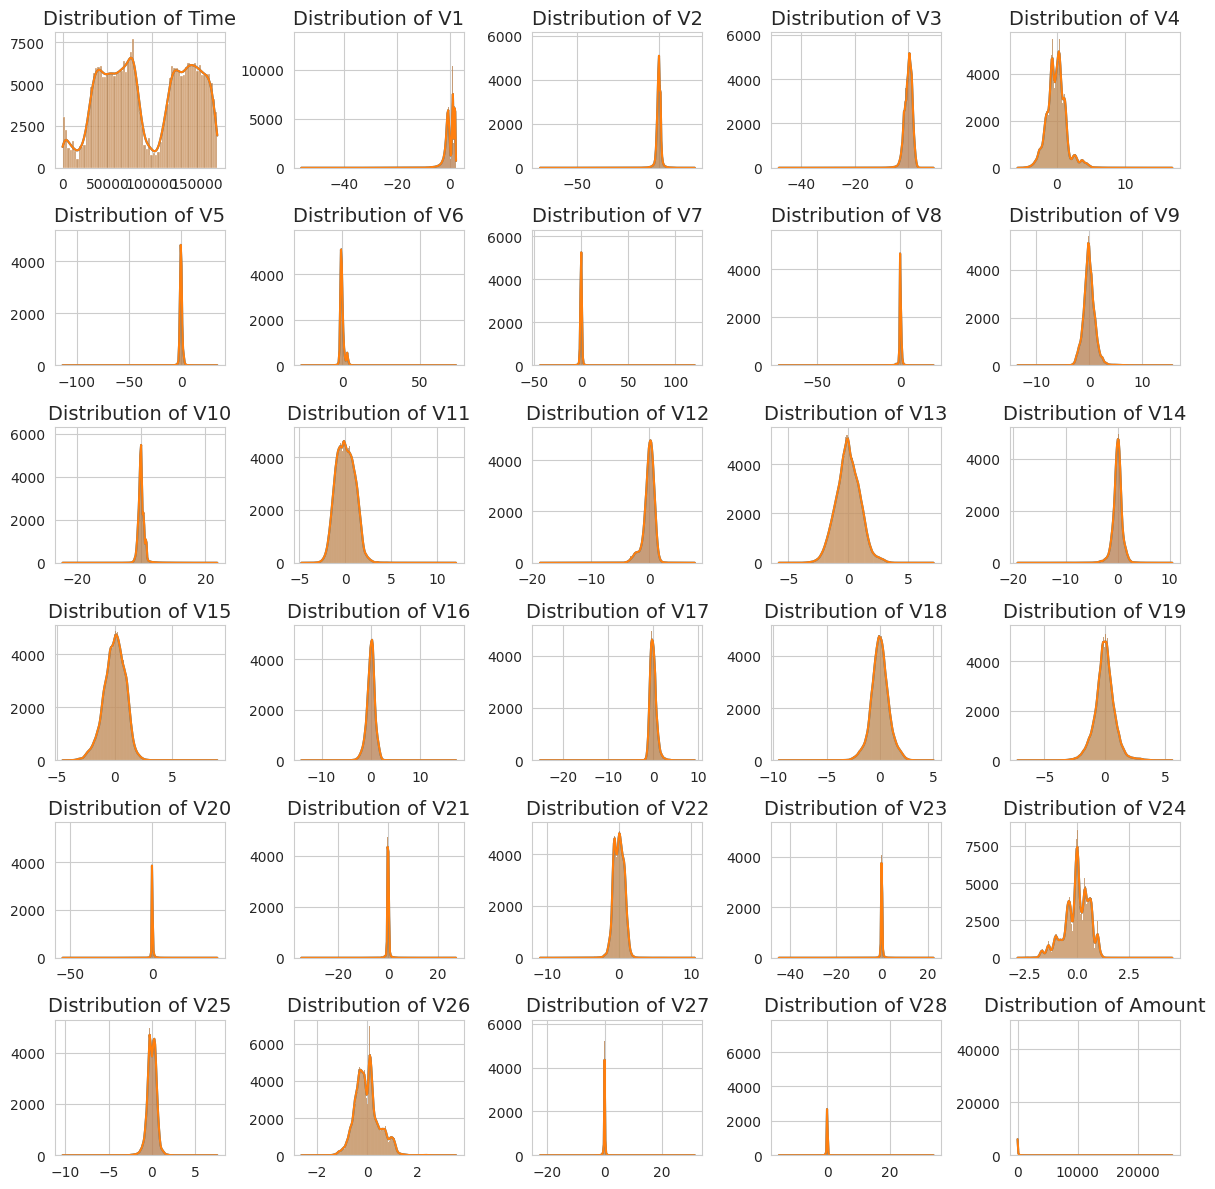

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots.
sns.set_style("whitegrid")

# Univariate Analysis: Plotting distributions of a couple of operational variables (X1, X2) and all management variables (A to E)

# Selecting variables for univariate analysis
variables_to_plot = features

# Creating subplots
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(12, 12))
axes = axes.flatten()  # Flattening the 2D array of axes for easy iteration

for i, col in enumerate(variables_to_plot):
    sns.histplot(df[col], kde=True, ax=axes[i])
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Removing empty subplots
for ax in axes[i+1:]:
    ax.remove()

plt.tight_layout()
plt.show()

대부분의 특성들이 0에 가장 빈도가 높은, 한번 scaled 된

### 2-3. 데이터 전처리  

- 기초 이진분류 연습 노트북([Basic Binary Classification using Scikit-learn](https://colab.research.google.com/drive/16oy4iiX6IKcKslCyMcEjGzbmmpptsxk2))에서 언급했듯이 본격적인 모델 학습 전의 데이터 처리 과정은 크게 결측치 확인 및 처리, 이상치 확인 및 처리, 특성 스케일링, 특성 변환(카테고리 변수로 변환 등)으로 나눌 수 있음  
- 여기에 추가로 경우에 따라 데이터셋에 있는 모든 특성을 모델의 input X로 넣지 않고, y 예측에 유의미한 특성 선택(feature selection)을 하거나 특성 엔지니어링(feature engineering)을 하여 새로운 특성을 생성하여 사용하는 것이 모델 성능을 향상시킬 수 있음
- 본 노트북은 기본적인 결측치 확인 및 처리, 이상치 확인 및 처리, 특성 스케일링을 먼저 실시하고 베이스라인 모델을 훈련시키고 모델 성능을 평가해본 다음 advanced feature engineering을 시도하여 모델의 성능 향상을 시도해보도록 하겠다.